In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

In [ ]:
mnist = tf.keras.datasets.cifar100 # Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

169009152/169001437 [==============================] - 11s 0us/step


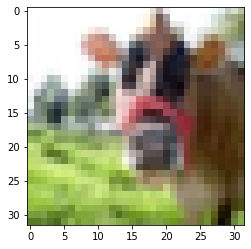

In [ ]:
plt.imshow(x_train[0]) # Import the image
plt.show()

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
 
    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3,kernel_size=1,strides=(1,1),padding='valid',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet50(input_shape = (32, 32, 3), classes = 100):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (3, 3), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [32, 32, 128], s = 1)
    X = identity_block(X, 3, [32, 32, 128])

    X = convolutional_block(X, f = 2, filters = [64, 64, 256], s = 2)
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2) 
    X = identity_block(X, 3, [128, 128, 512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 1) 
    X = identity_block(X, 3,  [256, 256, 1024])
    X = convolutional_block(X, f = 3, filters =  [256, 256, 1024], s = 1) 
    X = identity_block(X, 3,  [256, 256, 1024])
    
    X = convolutional_block(X, f = 3, filters =  [256, 256, 1024], s = 1) 
    X = identity_block(X, 3, [256, 256, 1024])
    X=tfl.Conv2D(filters=256,kernel_size=(1,1),strides=(1,1))(X)
    X = AveragePooling2D(pool_size=(2, 2))(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = ResNet50()
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 18, 18, 64)   1792        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 18, 18, 64)   256         conv2d_86[0][0]                  
____________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1), loss="sparse_categorical_crossentropy", metrics='accuracy'
)

In [ ]:
model.fit(x_train,y_train,epochs=75,batch_size=512,validation_data=(x_test,y_test))

Epoch 1/75
81/98 [=======================>......] - ETA: 6s - loss: 11.7391 - accuracy: 0.0147

In [ ]:
prediction=model.predict(x_test)


In [ ]:
prediction.shape

(10000, 10)

In [ ]:
reserve=tf.reshape(x_test,shape=(x_test.shape[0],28,28))

In [ ]:
model.evaluate(
    x=x_test, y=y_test, verbose=1,)

313/313 [==============================] - 1s 3ms/step - loss: 0.0755 - accuracy: 0.9770


[0.07552248239517212, 0.9769999980926514]

In [ ]:
prediction=model.predict(x_test)

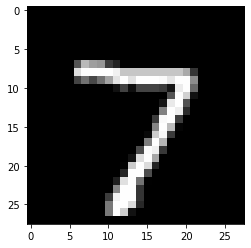

[6.1589037e-13 4.4784362e-10 1.4857122e-09 2.0990980e-09 2.6119584e-11
 1.4295531e-13 2.2086126e-18 1.0000000e+00 1.6133644e-10 5.8653224e-09]


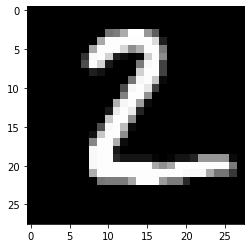

[2.2484088e-09 7.9900622e-07 9.9999893e-01 3.1488781e-07 3.7915593e-16
 1.1502686e-13 1.1047204e-09 6.2555017e-10 8.8539009e-10 3.3059831e-13]


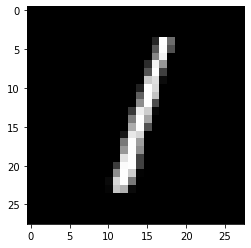

[1.5164448e-05 9.9996746e-01 3.4191899e-07 2.0655966e-09 1.0160085e-05
 7.4073135e-08 1.4357308e-06 4.1411658e-06 5.5777980e-07 6.0668611e-07]


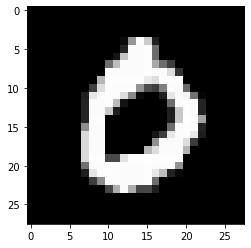

[9.9466407e-01 5.8547367e-09 8.5717629e-06 5.2568936e-07 1.3770672e-07
 4.7887693e-06 5.2808025e-03 7.7786119e-08 6.1684625e-07 4.0308238e-05]


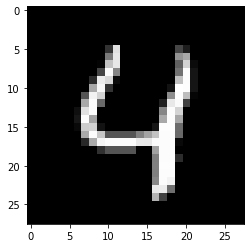

[1.5655063e-08 1.8909643e-07 3.9252450e-09 1.5007984e-09 9.9951732e-01
 1.5824510e-07 1.1274436e-06 2.4452692e-04 1.6609404e-06 2.3507133e-04]


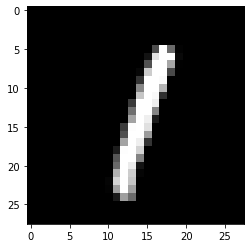

[5.8464877e-05 9.9992585e-01 4.4765716e-08 4.6313187e-10 2.0486564e-06
 3.7272830e-08 3.2708115e-07 5.6329695e-06 6.5840704e-06 1.0684785e-06]


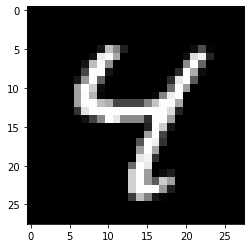

[2.9720554e-13 4.0146739e-07 1.4007964e-10 3.1598070e-08 9.5855761e-01
 4.8755201e-06 2.8440747e-06 2.7592178e-02 1.2827333e-02 1.0147889e-03]


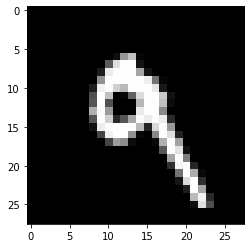

[4.38422049e-10 2.27150156e-08 3.47718128e-07 1.50811346e-07
 2.99551582e-04 1.03467228e-05 5.27194958e-15 8.75829187e-08
 1.15613926e-04 9.99573886e-01]


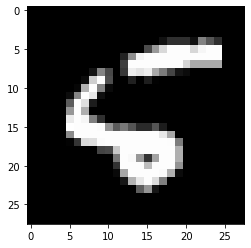

[1.1555982e-09 2.5762389e-12 2.1860073e-13 2.6657271e-10 7.5349985e-06
 5.6063913e-02 9.7989105e-04 2.6595124e-09 1.5539956e-05 9.4293320e-01]


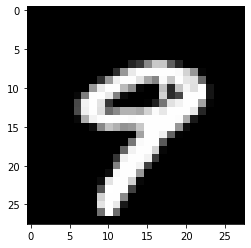

[1.1983779e-14 9.8532544e-17 1.8928086e-13 2.9981060e-09 1.6780525e-05
 1.8772211e-11 4.2612118e-15 1.0491580e-04 1.1839255e-06 9.9987710e-01]


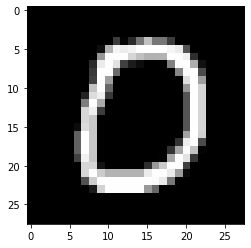

[9.9999917e-01 3.4688235e-15 1.8672464e-08 1.5081314e-10 2.6849153e-11
 1.0155364e-10 7.7288598e-07 9.2822583e-11 6.9878814e-10 2.9543072e-08]


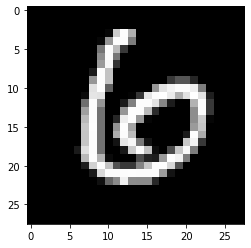

[3.0173835e-05 1.0380803e-13 3.1908382e-11 1.5013777e-11 1.1648040e-08
 2.9205512e-07 9.9996901e-01 1.3763699e-12 5.5592199e-07 7.5280497e-08]


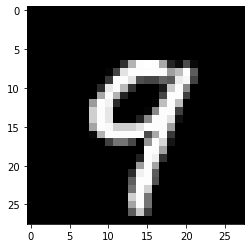

[4.7205816e-12 9.9369948e-13 1.6495327e-13 2.0228523e-08 4.9306215e-07
 1.5837284e-09 1.4113057e-16 2.6598022e-07 1.4504103e-07 9.9999905e-01]


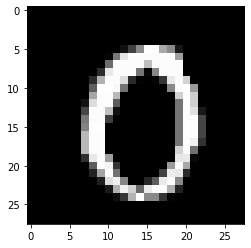

[9.9999964e-01 2.5241346e-13 4.0891707e-11 3.0571084e-11 2.6585303e-11
 7.6494769e-11 2.9548131e-10 2.0542090e-10 3.8937253e-09 3.8615821e-07]


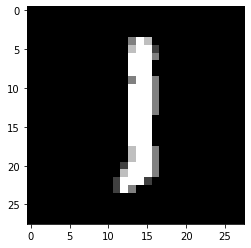

[1.73798892e-11 9.99999881e-01 7.93001109e-10 2.46033682e-09
 5.38048450e-09 2.34891800e-10 1.18332174e-07 1.40466516e-09
 2.75371792e-09 8.63033256e-11]


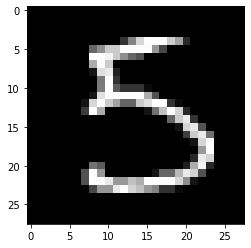

[1.27191825e-11 1.07036819e-11 1.14987952e-09 1.15754779e-06
 1.62168954e-12 9.99997973e-01 1.91832541e-08 6.72063095e-07
 2.57122714e-08 2.36870846e-07]


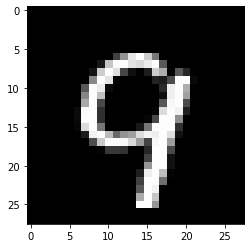

[4.4892676e-09 8.9708514e-13 2.2883104e-09 4.4736275e-06 4.9296312e-05
 2.3627737e-07 1.3510678e-09 9.5978821e-06 8.8545276e-05 9.9984777e-01]


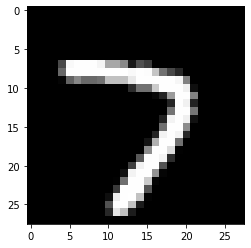

[6.62870583e-12 2.88765878e-09 4.91860819e-09 1.43297825e-07
 5.81909035e-11 1.29056306e-11 3.73464139e-17 9.99999166e-01
 3.35103834e-10 7.28577731e-07]


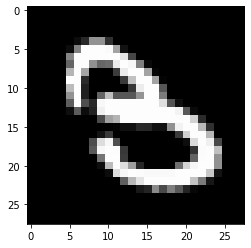

[4.80707785e-09 6.18401094e-11 9.49928491e-08 7.96440303e-01
 1.37703282e-09 1.00580626e-04 8.41588815e-07 7.95848595e-11
 2.03116387e-01 3.41844512e-04]


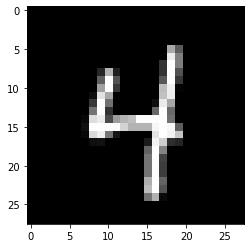

[3.2412081e-12 1.6636655e-07 2.3404533e-08 3.1017570e-11 9.9999356e-01
 1.2272480e-11 1.0707596e-11 5.3842573e-06 4.5629340e-09 8.1301908e-07]


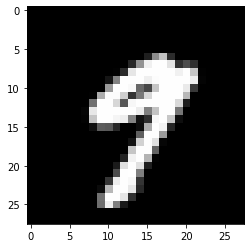

[3.7867119e-13 1.4944459e-07 3.2251454e-12 2.1766809e-06 1.9532858e-05
 3.5364436e-09 4.8349636e-16 2.2340266e-03 6.3136705e-09 9.9774408e-01]


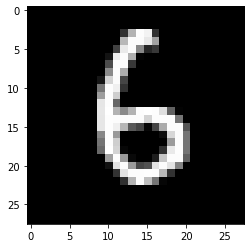

[1.5143118e-07 4.9397270e-13 4.2751022e-08 3.0945754e-10 1.3421651e-07
 7.7273999e-03 9.9226898e-01 3.6878753e-10 3.3463214e-06 9.9095658e-08]


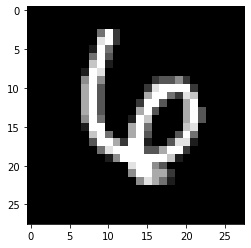

[5.6748645e-06 3.2602128e-09 1.2056050e-07 1.5608398e-09 3.3335526e-02
 1.5451521e-06 9.6598136e-01 4.9306941e-06 6.1185489e-04 5.9031398e-05]


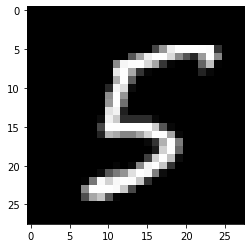

[3.2519956e-10 1.6761367e-14 2.8901496e-11 2.4302969e-07 6.6530418e-13
 9.9997163e-01 1.8807321e-05 8.4139275e-12 2.2810774e-08 9.2606733e-06]


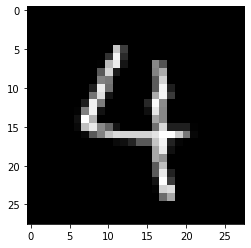

[2.6315990e-07 1.7640724e-06 2.7670261e-05 5.8029366e-07 9.9797565e-01
 2.6743860e-06 5.2455272e-07 1.4617007e-03 3.9541846e-05 4.8968638e-04]


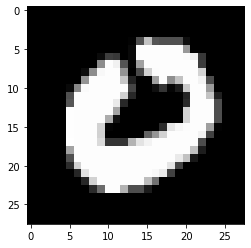

[1.0000000e+00 1.2114126e-16 7.1061257e-10 5.9336598e-12 2.5653000e-12
 5.5468867e-13 2.0763411e-09 9.9929665e-12 6.5615713e-10 4.1020286e-08]


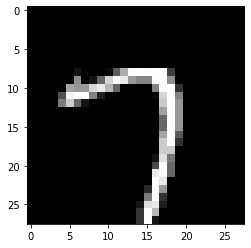

[2.1775101e-08 2.5128746e-09 4.9572172e-06 1.3823495e-05 1.6124838e-10
 3.9884647e-09 2.9694161e-18 9.9992692e-01 4.8246852e-07 5.3735192e-05]


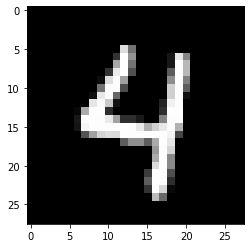

[7.4206581e-13 1.2194336e-09 3.6840773e-11 5.0905885e-12 9.9996948e-01
 4.5166813e-09 5.5830635e-12 2.3882283e-08 4.2865231e-09 3.0536226e-05]


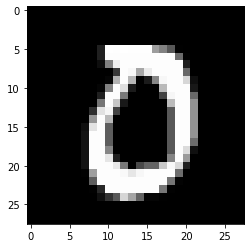

[9.9999201e-01 1.3896816e-11 2.4029037e-08 6.0700515e-08 5.4197511e-11
 2.1307345e-07 1.3114297e-11 8.2127009e-08 7.5359308e-06 3.8910098e-08]


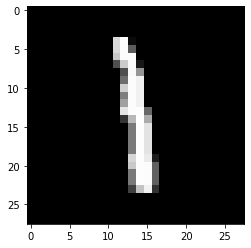

[6.3702342e-13 9.9986291e-01 3.3484213e-07 1.7440352e-05 9.6298201e-05
 3.2027188e-07 3.8105256e-07 1.4178784e-07 1.5515308e-05 6.5059612e-06]


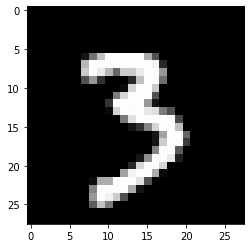

[6.1702173e-16 9.6780639e-10 1.5808726e-12 9.9984932e-01 1.8183884e-10
 1.4830623e-07 7.5450916e-18 1.4885948e-08 7.9203227e-10 1.5059208e-04]


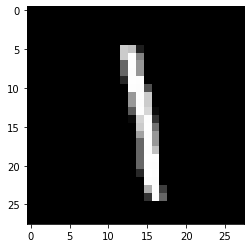

[6.1103344e-14 9.9999487e-01 2.6240931e-08 1.8294393e-09 4.1389731e-06
 3.2838201e-11 8.1037814e-07 3.0530051e-10 3.4836336e-08 5.0503694e-08]


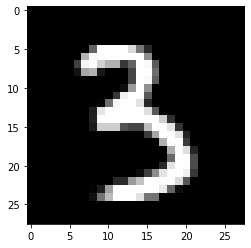

[1.0930939e-16 7.2592119e-12 2.7019145e-10 9.9999666e-01 5.1118961e-13
 3.2142875e-06 3.8855238e-16 4.4975814e-09 1.6217156e-08 4.9793492e-08]


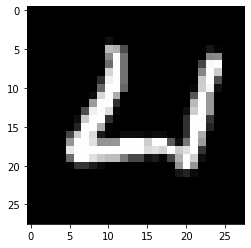

[6.6728918e-03 7.9300489e-06 9.5963890e-07 2.9175894e-11 9.2814344e-01
 7.3773322e-07 6.5172918e-02 2.4234265e-07 4.7011753e-07 3.0269470e-07]


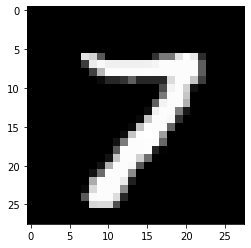

[9.2821506e-12 3.2568884e-08 4.5483741e-08 3.3539771e-07 1.5069465e-11
 6.2529829e-12 5.6671719e-17 9.9999964e-01 4.1166275e-09 4.5197730e-09]


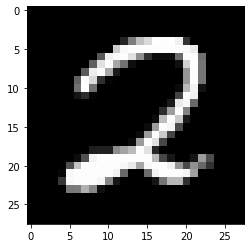

[2.84982871e-10 2.13065765e-09 9.99999762e-01 9.69643708e-08
 2.11579465e-13 4.52812328e-14 1.18217307e-15 1.09248944e-07
 3.78071485e-09 1.27515193e-10]


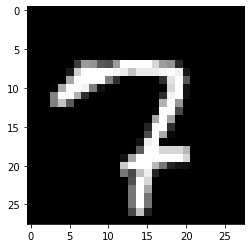

[6.4073882e-13 7.7303712e-11 2.7735878e-04 6.3018649e-07 1.2221876e-10
 3.2278989e-11 8.7918354e-17 9.9972183e-01 6.7956463e-09 2.4577886e-07]


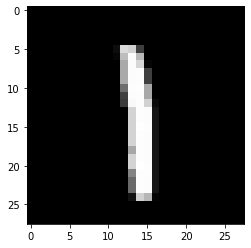

[1.7731017e-15 9.9998796e-01 3.3556175e-11 3.7688536e-10 9.2501714e-06
 3.9879433e-11 1.8546533e-08 8.8988434e-09 4.7324273e-09 2.7119850e-06]


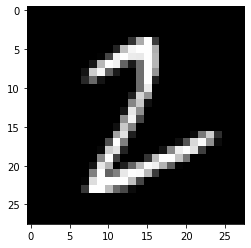

[1.7923162e-07 1.2535788e-04 9.9977010e-01 5.5560076e-06 2.5072613e-10
 2.4077812e-10 4.9889529e-08 9.8729441e-05 2.1965434e-08 7.7708076e-11]


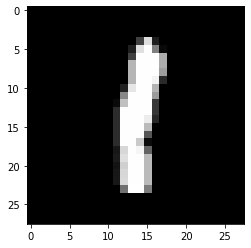

[6.3596985e-06 9.9998546e-01 5.4424589e-09 2.9327474e-08 6.2512854e-08
 1.0009813e-08 4.5006186e-06 3.6026105e-08 3.2308994e-06 2.4602755e-07]


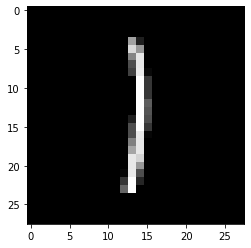

[7.0076910e-11 9.9998665e-01 5.8305471e-08 1.0934294e-08 1.1368236e-05
 1.0555230e-09 6.0336669e-07 9.9107547e-07 2.2057483e-08 3.7058442e-07]


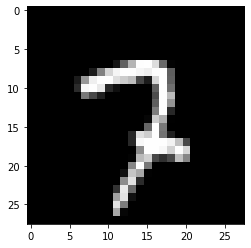

[6.2289631e-12 6.4843285e-08 2.3791425e-04 6.0252927e-04 1.3040366e-08
 3.2079833e-10 3.6963938e-15 9.9914968e-01 3.6317377e-07 9.2703112e-06]


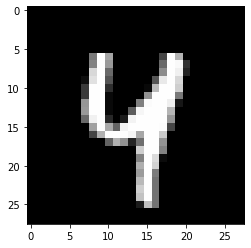

[8.0509980e-14 2.5478963e-07 1.5358584e-12 8.8567415e-10 9.9777395e-01
 8.7584882e-09 2.8507077e-10 3.0542974e-06 1.0133587e-08 2.2226793e-03]


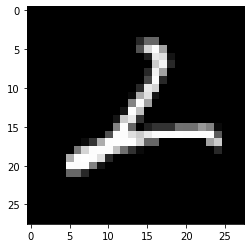

[9.3808644e-08 1.3939172e-04 9.9773091e-01 2.9186009e-05 1.8730956e-03
 2.3198773e-08 1.8797407e-04 1.3478039e-05 2.5940089e-05 1.0842577e-09]


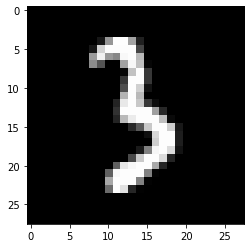

[6.2176078e-08 3.0996664e-06 5.6640396e-04 9.9806064e-01 2.6883818e-08
 3.4370917e-04 3.6612342e-08 1.4477811e-05 1.0106694e-03 7.7469934e-07]


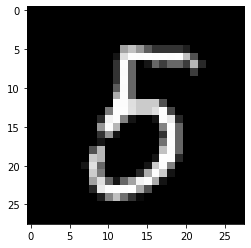

[1.5251924e-08 9.3160982e-16 1.4642697e-08 1.3818542e-05 3.4024643e-12
 9.9770015e-01 1.3906014e-06 3.0003489e-10 2.2838833e-03 7.1915935e-07]


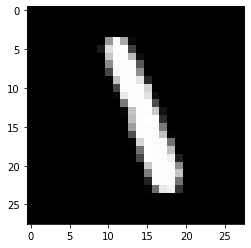

[4.6983571e-15 9.9991071e-01 6.7602996e-06 1.1850932e-05 1.1544660e-06
 1.3100520e-09 2.9090731e-07 1.8446410e-10 6.5693290e-05 3.5645412e-06]


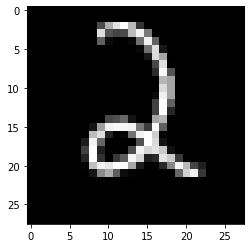

[1.3725314e-09 8.0674853e-09 9.9999952e-01 3.0577297e-07 2.5464708e-09
 2.5108287e-13 1.8822384e-10 5.2171512e-09 1.4852908e-07 1.4017093e-10]


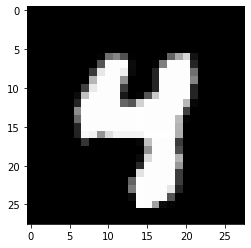

[4.9327903e-10 1.2644421e-08 7.5025924e-10 5.9812896e-07 9.8101246e-01
 9.9191195e-05 1.8587096e-09 5.4346176e-05 2.3470271e-05 1.8809957e-02]


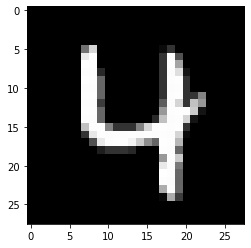

[3.7002899e-13 2.9197922e-10 1.2047645e-12 2.8134111e-13 9.9999189e-01
 2.5733734e-13 1.3993018e-11 7.9719866e-06 3.6296807e-10 1.6525053e-07]


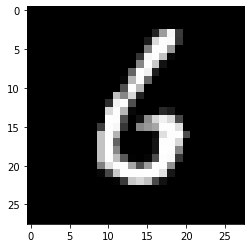

[4.4303531e-05 5.7209865e-05 8.2106071e-06 2.4206076e-07 2.5072601e-03
 3.5763430e-04 9.8168218e-01 9.6818935e-09 1.5342785e-02 1.6999556e-07]


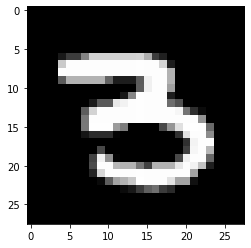

[1.8134975e-14 2.9202806e-12 3.4889808e-10 1.0000000e+00 2.3376949e-18
 5.0860804e-10 2.0490508e-15 2.5500843e-12 5.8691302e-08 2.1666177e-10]


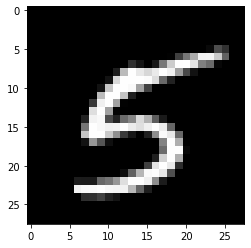

[2.1736400e-05 3.9398870e-10 1.4811010e-07 2.3797889e-05 2.5611567e-07
 9.9978107e-01 5.8428268e-05 2.3732468e-06 2.7205013e-05 8.4979227e-05]


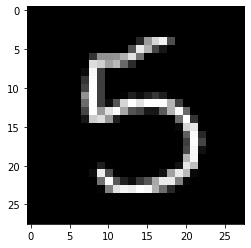

[1.8739470e-08 3.3092411e-12 8.4495612e-11 2.6970406e-06 1.0092207e-09
 9.9985802e-01 5.6124878e-07 2.1658744e-08 6.3949235e-05 7.4664975e-05]


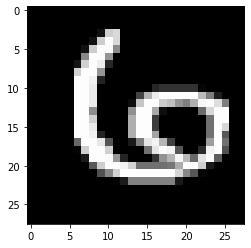

[3.33361272e-09 8.53011941e-16 7.25684866e-13 7.16557673e-13
 1.98621830e-09 5.54117818e-08 9.99999642e-01 6.91319723e-13
 3.16243501e-07 1.07418685e-10]


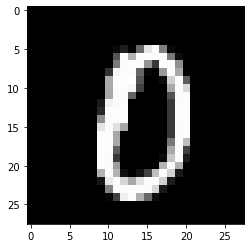

[9.99996781e-01 2.01023767e-10 2.20552576e-09 1.01380608e-13
 3.15982240e-10 3.80653148e-11 2.95276976e-07 5.03552963e-11
 3.01939713e-06 1.11347105e-10]


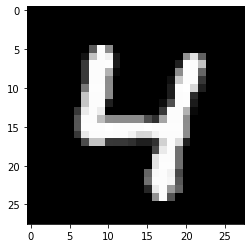

[1.1649455e-14 1.9664283e-10 4.0766280e-14 6.1725281e-15 9.9999821e-01
 1.6933758e-11 6.7089862e-12 1.7484189e-06 4.7135872e-12 2.5988571e-09]


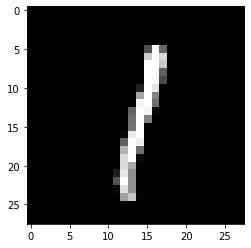

[2.0100950e-05 9.9996328e-01 2.2545703e-07 8.3317181e-10 5.4053012e-06
 8.8545143e-10 1.9819643e-07 9.3142789e-06 8.0046266e-07 5.7401695e-07]


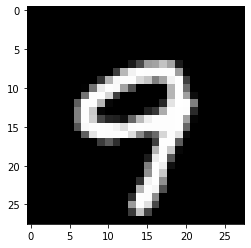

[2.3090346e-11 1.6781217e-14 2.0433807e-13 2.4561821e-08 1.7104028e-08
 1.2077864e-10 4.9178657e-17 4.3117967e-07 1.9589424e-07 9.9999928e-01]


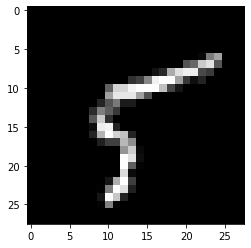

[1.09814080e-09 4.64876332e-11 2.69772151e-08 2.19944781e-07
 1.04508594e-07 9.99714911e-01 2.16074110e-08 3.99630471e-06
 2.61048117e-04 1.96882738e-05]


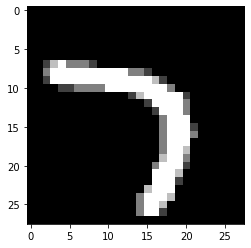

[6.3650894e-12 2.9156766e-10 6.9542945e-09 9.0436122e-05 1.1723861e-11
 3.8892081e-09 2.0173889e-18 9.9990892e-01 3.4787178e-09 5.4701565e-07]


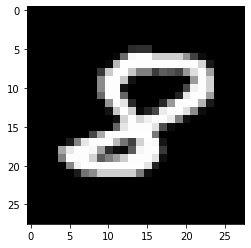

[2.8123517e-10 1.4898244e-14 1.9610256e-02 6.3667394e-02 4.8120091e-11
 5.6566412e-05 1.7791729e-10 5.0339882e-10 9.1666406e-01 1.7816353e-06]


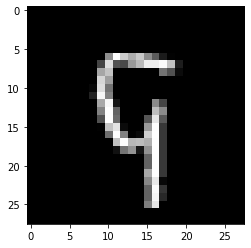

[4.4099956e-13 3.3184422e-06 5.2377999e-07 6.1012182e-05 3.6408025e-04
 3.5280548e-04 2.0750244e-06 5.0657487e-05 9.3662314e-04 9.9822897e-01]


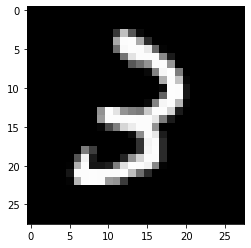

[3.74280260e-11 5.73727599e-09 2.33181626e-01 7.54981279e-01
 7.24507314e-13 1.37279500e-07 1.14095785e-13 2.36644628e-05
 1.18131535e-02 1.22115807e-07]


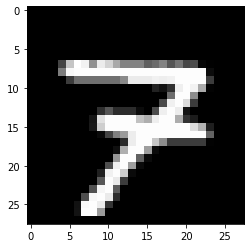

[2.8112632e-15 5.9693075e-14 1.2158526e-08 3.5713548e-08 2.3854041e-09
 1.7968483e-12 4.0816641e-16 9.9999976e-01 1.6608634e-07 9.4772950e-08]


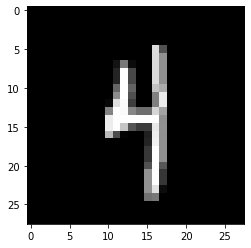

[2.0265413e-12 2.4459976e-05 1.6784586e-10 4.8349293e-11 9.9931896e-01
 4.9635642e-09 2.8135985e-10 1.1638599e-05 4.0147436e-09 6.4499927e-04]


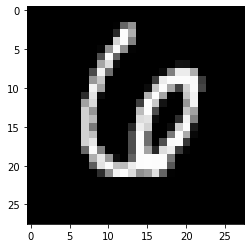

[6.8300846e-04 1.4948974e-07 1.0180799e-07 3.3713757e-08 3.8806465e-05
 6.9913317e-06 9.9923408e-01 7.1036941e-09 1.9695956e-06 3.4804376e-05]


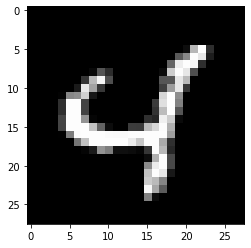

[6.6830746e-10 4.3555275e-09 3.1339417e-11 1.6771752e-10 9.9947697e-01
 1.4596962e-08 2.4562798e-09 2.7738989e-07 2.0970221e-07 5.2261230e-04]


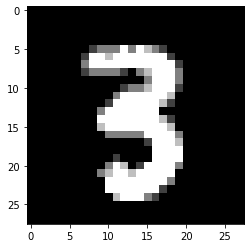

[4.3606481e-13 1.1599819e-08 1.9060632e-08 9.9997866e-01 1.1124277e-10
 4.4770431e-06 2.3270487e-14 1.5963702e-05 2.5732271e-07 5.9055418e-07]


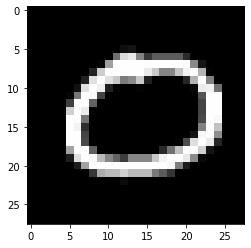

[9.9999034e-01 9.0070068e-13 2.5593470e-08 3.3754009e-12 4.4239898e-10
 3.1727913e-07 9.2066020e-06 2.5133994e-08 2.7099539e-10 8.5545970e-08]


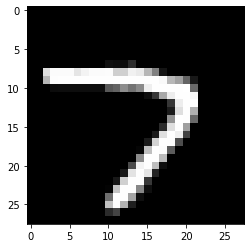

[7.67351569e-13 1.92720861e-09 1.05429443e-09 7.63131311e-07
 3.99392359e-11 1.28561584e-09 1.24021886e-17 9.99998808e-01
 9.86091417e-11 4.39475400e-07]


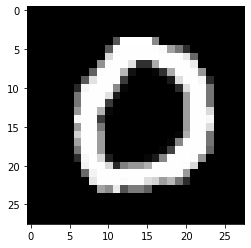

[1.0000000e+00 8.7281617e-20 4.2812021e-10 7.4867265e-12 2.6756998e-15
 4.7110487e-13 1.7924963e-10 4.5702415e-14 4.4186980e-12 1.5766561e-09]


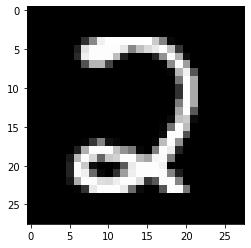

[2.6571452e-09 7.2339956e-09 9.9985707e-01 3.5118235e-05 1.4170396e-15
 1.4334919e-11 4.0063000e-13 1.0780392e-04 5.6670701e-12 7.7480397e-11]


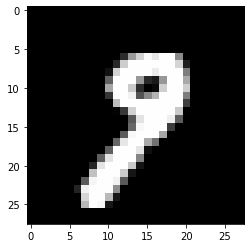

[1.1746789e-07 1.2522531e-07 7.7616742e-06 5.9670573e-03 2.8824629e-06
 6.1338852e-08 1.7057285e-14 1.5100306e-01 1.9144178e-03 8.4110451e-01]


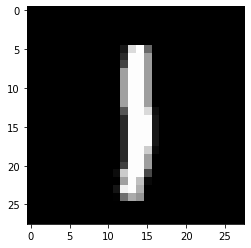

[5.1613657e-12 9.9999869e-01 3.0405036e-11 6.1052524e-11 1.1811145e-06
 9.0288665e-11 4.4032632e-08 1.5835707e-09 1.4599645e-09 1.6235595e-07]


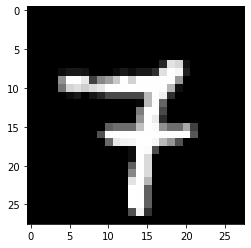

[1.8995065e-20 1.2578341e-09 1.1078222e-09 4.9353180e-06 1.7335990e-09
 1.2590844e-13 2.2572553e-17 9.9999511e-01 4.1150364e-10 7.8318296e-11]


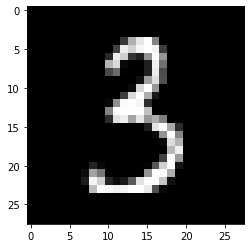

[2.6465188e-10 9.2092836e-07 1.0995728e-06 9.9842656e-01 2.4538494e-06
 9.0386922e-04 1.9005282e-09 4.5605566e-07 1.6550033e-04 4.9917464e-04]


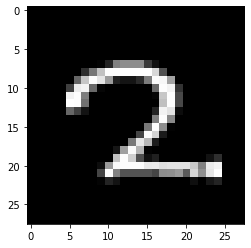

[5.9821904e-12 5.1799620e-11 9.9998403e-01 9.7519447e-08 1.3993367e-14
 9.1131204e-13 3.3640171e-19 1.5854986e-05 1.7196312e-11 6.1122390e-10]


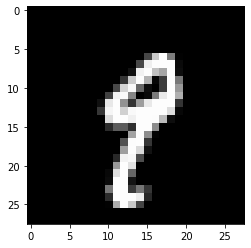

[1.6151915e-09 1.4088523e-06 7.7176061e-09 2.9562556e-04 8.0365743e-07
 7.7726526e-08 2.1513211e-13 1.6923473e-04 1.8794501e-05 9.9951398e-01]


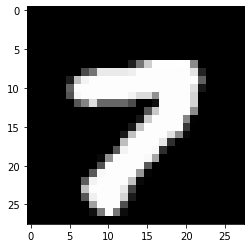

[3.6431402e-14 3.7510731e-10 1.0499702e-08 4.2551951e-06 4.7519294e-11
 4.2475783e-11 4.3886331e-19 9.9999309e-01 4.7393165e-09 2.6326338e-06]


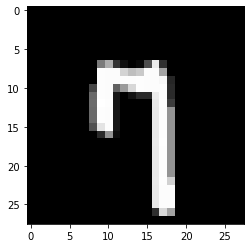

[2.5922218e-09 4.1244448e-06 5.5150049e-09 6.7530532e-09 4.7847482e-07
 3.4503021e-08 2.0762773e-12 9.9902344e-01 9.4202574e-07 9.7096828e-04]


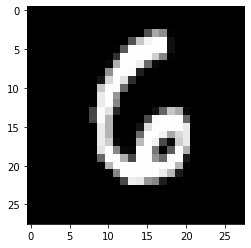

[1.1368704e-07 2.9283898e-11 9.4533149e-08 4.9020872e-09 4.1042147e-09
 4.2621954e-04 9.9955493e-01 4.0695849e-11 1.7329419e-05 1.2402074e-06]


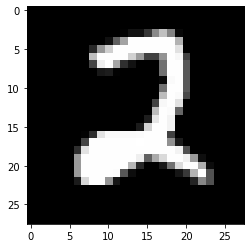

[2.9392863e-15 6.0705790e-10 9.9999988e-01 1.9570754e-08 3.3004071e-15
 1.1479529e-17 5.5067643e-17 1.2541712e-07 1.8621954e-10 5.8586842e-15]


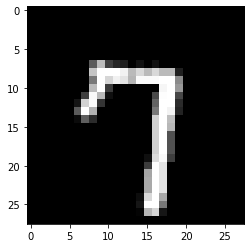

[1.9073361e-12 7.8573958e-10 1.1954886e-10 2.3688598e-09 7.6867158e-11
 8.2408630e-13 8.0460517e-16 9.9999988e-01 1.8123935e-11 7.6796496e-08]


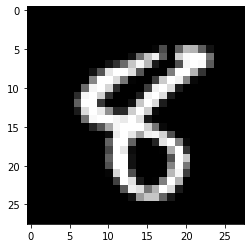

[7.1175433e-14 1.9743070e-15 6.3342738e-12 3.0613204e-08 9.4667163e-10
 2.6244950e-07 2.7569399e-08 1.2374301e-12 9.9999964e-01 9.7814512e-09]


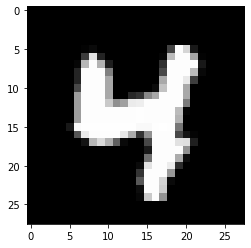

[1.9629846e-14 1.3098029e-08 2.6021349e-14 3.7907642e-15 9.9999857e-01
 6.9384685e-11 2.5322911e-13 8.7841886e-07 1.7086804e-11 5.3726478e-07]


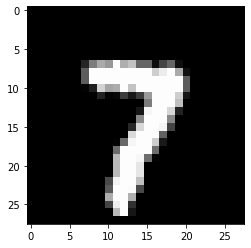

[6.6547173e-08 4.0911908e-07 3.3929668e-06 8.0052843e-05 1.2841855e-09
 1.0974352e-10 4.9466354e-17 9.9986601e-01 7.0187216e-06 4.3068874e-05]


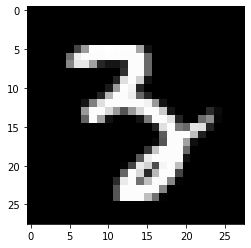

[2.0632651e-09 3.0811931e-10 2.5488244e-04 9.9956292e-01 8.7835600e-11
 1.3326177e-04 8.7198526e-13 4.6721318e-05 2.2270985e-06 8.6289402e-09]


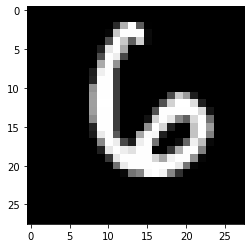

[1.1069938e-08 1.5776749e-14 3.8832576e-11 1.4990034e-11 2.1722837e-09
 4.5630153e-09 1.0000000e+00 9.8450445e-15 4.1077676e-08 1.2084093e-10]


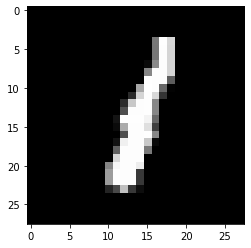

[2.2475813e-06 9.9974579e-01 8.7503003e-07 4.3449731e-07 3.5637683e-07
 1.5108303e-07 5.6258414e-06 5.4556181e-06 2.3889929e-04 3.4888313e-07]


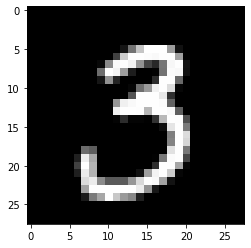

[1.0538408e-09 2.1825872e-12 1.5015404e-08 9.9997473e-01 2.7154889e-14
 9.5917521e-08 5.7185037e-15 1.9548800e-09 1.0373651e-05 1.4820281e-05]


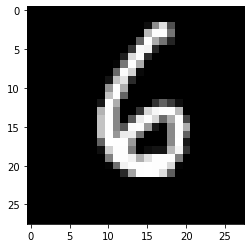

[4.9973628e-06 3.5124511e-08 5.4421262e-06 3.9371568e-07 2.5254509e-05
 3.8239892e-04 9.9950135e-01 1.2060387e-10 7.3590723e-05 6.4893529e-06]


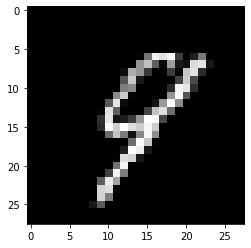

[2.8598336e-07 2.2415422e-06 2.1367901e-08 7.6343655e-05 2.6467786e-05
 8.6236909e-08 3.9275600e-11 1.5830455e-03 3.1693489e-04 9.9799454e-01]


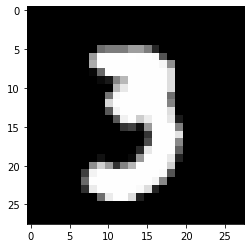

[4.5401627e-10 3.4713423e-07 1.6621119e-11 9.9898380e-01 2.7607515e-11
 9.6591439e-06 3.7765144e-16 1.3184177e-07 1.9884505e-06 1.0040243e-03]


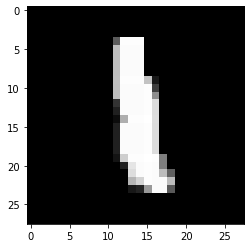

[3.32083096e-14 9.99996305e-01 4.19690949e-09 4.06463530e-09
 2.01916546e-08 1.09226322e-10 1.36909352e-06 7.97471626e-13
 2.22435733e-06 1.14363345e-08]


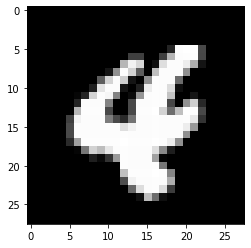

[5.8199361e-09 1.0986531e-06 3.0246605e-07 3.0606580e-11 9.8763961e-01
 2.6553943e-08 2.3174827e-05 4.6843641e-07 7.1470410e-04 1.1620569e-02]


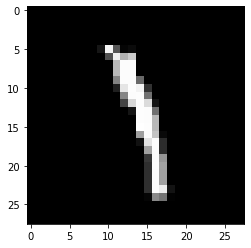

[8.0498482e-13 9.9742353e-01 2.3102808e-07 2.8205443e-06 2.5230579e-03
 1.1650061e-07 4.7541771e-06 4.4495917e-07 1.7749693e-05 2.7313170e-05]


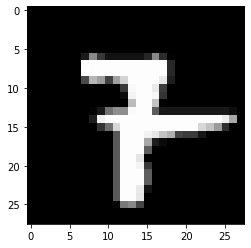

[1.9120807e-15 1.3358142e-09 1.7950621e-08 5.0425081e-07 2.1169573e-07
 5.2388527e-10 7.4956760e-12 9.9999869e-01 5.9298088e-07 8.2628843e-10]


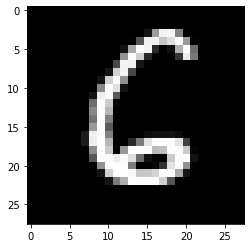

[2.0784933e-06 9.0325365e-11 7.6599465e-09 1.2400578e-10 6.0454475e-08
 8.9525720e-06 9.9997211e-01 2.2025925e-12 1.6598533e-05 2.0311070e-07]


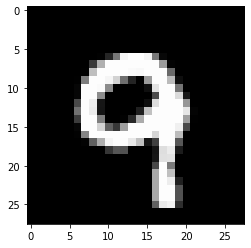

[8.11826897e-13 1.49249340e-14 1.05408405e-13 1.40087934e-07
 6.59932331e-10 2.92001388e-11 2.98191321e-19 4.71426631e-09
 6.17802556e-08 9.99999762e-01]


In [ ]:
import numpy as np
for i in range(100):
  plt.imshow(reserve[i], cmap="gray") # Import the image
  plt.show()
  print(prediction[i])
